In [2]:
!pip install datasets
!pip install accelerate
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
import os
import glob
import numpy as np
import pandas as pd
from PIL import Image

import seaborn as sns
import matplotlib.image as img
import matplotlib.pyplot as plt

In [5]:
from datasets import load_dataset
from datasets.features import ClassLabel

ds_train = load_dataset("imagefolder", data_dir="/content/drive/MyDrive/ml2/ML_project_2_course/datasets/Augmentation/horizontal/horizontal_train")


Resolving data files:   0%|          | 0/2186 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [6]:
ds_test = load_dataset("imagefolder", data_dir="/content/drive/MyDrive/ml2/ML_project_2_course/datasets/Augmentation/horizontal/horizontal_test")


Resolving data files:   0%|          | 0/316 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [7]:
from datasets import DatasetDict
ds = DatasetDict({
    'train': ds_train['train'],
    'test': ds_test['train'],
    })

In [8]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 2185
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 315
    })
})

In [9]:
ds = ds.class_encode_column("labels")

Stringifying the column:   0%|          | 0/2185 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/2185 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/315 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/315 [00:00<?, ? examples/s]

In [10]:
ex = ds['train'][400]
ex

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x360>,
 'labels': 0}

In [11]:
ds['train'].num_rows

2185

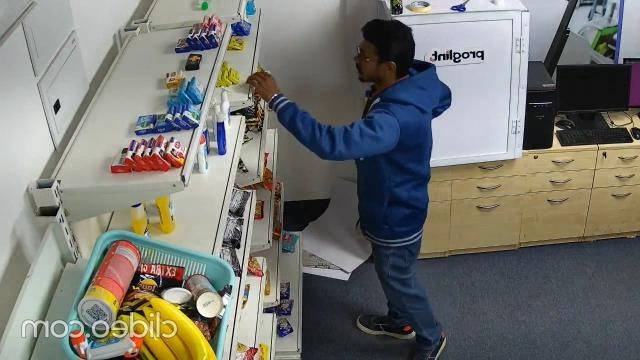

In [12]:
image = ex['image']
image

In [13]:
labels = ds['train'].features['labels']
labels

ClassLabel(names=['0', '1'], id=None)

In [14]:
labels.int2str(ex['labels'])

'0'

In [15]:
# def get_augmented_dict(ds):
#   augmented_pictures = []
#   for i in range(ds.num_rows):

In [49]:
import torch
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator
from PIL import Image

def crop_image(image, box):
    additional_area = 1/10
    x_min, y_min, x_max, y_max = box
    width, height = image.size
    box_width = x_max - x_min
    box_height = y_max - y_min
    x_min_2 = max(0, x_min - box_width*additional_area)
    y_min_2 = max(0, y_min - box_height*additional_area)
    x_max_2 = min(width, x_max + box_width*additional_area)
    y_max_2 = min(height, y_max + box_height*additional_area)
    area = (x_min_2, y_min_2, x_max_2, y_max_2)
    cropped_img = image.crop(area)
    return cropped_img

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_detect = YOLO('yolov8n.pt').to(device)
model_detect.classes = [0]

def recieve_box(image):
    results = model_detect(source = image, classes=0, show = False, imgsz=640, conf=0.2, iou=0.4, save = False, verbose=False)
    boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)
    cropped_images = []
    for box in boxes:
        cropped_images.append(crop_image(image, box))
    return cropped_images

In [29]:
ex_cropped_images = recieve_box(ex['image'])

ex_cropped_images

[<PIL.Image.Image image mode=RGB size=249x360>]

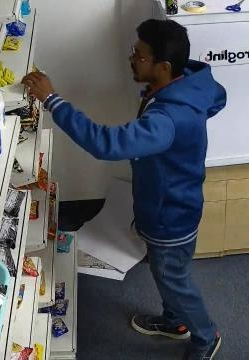

In [30]:
ex_cropped_images[0]

In [34]:
from tqdm.auto import tqdm

In [39]:
ds_split_name = 'train'
dict_train_detected = {'image' : [], 'labels': []}
for i in tqdm(range(ds[ds_split_name].num_rows)):
  img = recieve_box(ds[ds_split_name][i]['image'])
  label = ds[ds_split_name][i]['labels']
  if(len(img) > 0):
    dict_train_detected['image'].append(img[0])
    dict_train_detected['labels'].append(label)
  # for box_img in img:
  #   ds_train_detected[i] = {'image': box_img,'labels': label}


  0%|          | 0/2185 [00:00<?, ?it/s]

In [40]:
from datasets import Dataset

ds_train_detected_new = Dataset.from_dict(dict_train_detected)

ds_train_detected_new

Dataset({
    features: ['image', 'labels'],
    num_rows: 2182
})

In [50]:
ds_split_name = 'test'
dict_test_detected = {'image' : [], 'labels': []}
for i in tqdm(range(ds[ds_split_name].num_rows)):
  img = recieve_box(ds[ds_split_name][i]['image'])
  label = ds[ds_split_name][i]['labels']
  if(len(img) > 0):
    dict_test_detected['image'].append(img[0])
    dict_test_detected['labels'].append(label)

  0%|          | 0/315 [00:00<?, ?it/s]

In [51]:
from datasets import Dataset

ds_test_detected_new = Dataset.from_dict(dict_test_detected)

ds_test_detected_new

Dataset({
    features: ['image', 'labels'],
    num_rows: 315
})

In [53]:
ds_detected = DatasetDict({
    'train': ds_train_detected_new,
    'test': ds_test_detected_new,
    })

ds_detected = ds_detected.class_encode_column("labels")

Stringifying the column:   0%|          | 0/2182 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/2182 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/315 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/315 [00:00<?, ? examples/s]

In [82]:
ds_detected

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 2182
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 315
    })
})

In [83]:
from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

In [84]:
def process_example(example):
    inputs = processor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs

In [85]:
process_example(ds_detected['train'][0])

{'pixel_values': tensor([[[[-0.3647, -0.3882, -0.4039,  ..., -0.7255, -0.7725, -0.8118],
          [-0.3647, -0.3882, -0.4039,  ..., -0.7490, -0.7882, -0.8275],
          [-0.3647, -0.3882, -0.4039,  ..., -0.7725, -0.8039, -0.8196],
          ...,
          [-0.3725, -0.2471, -0.2314,  ..., -0.5216, -0.5529, -0.5294],
          [-0.0588, -0.0667, -0.4275,  ..., -0.4980, -0.5137, -0.5294],
          [-0.2706,  0.1529, -0.2314,  ..., -0.5373, -0.5216, -0.5529]],

         [[-0.4039, -0.4118, -0.4275,  ..., -0.7333, -0.7725, -0.8118],
          [-0.4039, -0.4118, -0.4275,  ..., -0.7569, -0.7882, -0.8275],
          [-0.4039, -0.4118, -0.4275,  ..., -0.7804, -0.8039, -0.8196],
          ...,
          [-0.5922, -0.4824, -0.4824,  ..., -0.4667, -0.4980, -0.4745],
          [-0.2784, -0.3098, -0.6941,  ..., -0.4431, -0.4588, -0.4745],
          [-0.4902, -0.0980, -0.4980,  ..., -0.4824, -0.4667, -0.4980]],

         [[-0.4510, -0.4667, -0.4824,  ..., -0.7490, -0.7882, -0.8275],
          [-0

In [86]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = processor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

In [87]:
prepared_ds = ds_detected.with_transform(transform)

In [88]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [89]:
import numpy as np

from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [90]:
from transformers import ViTForImageClassification

labels = ds_detected['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [91]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="/content/drive/MyDrive/ml2/ML_project_2_course/weights1",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  save_total_limit=5,
  logging_steps=10,
  learning_rate=2e-4,
  weight_decay=0.01,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [92]:
training_args.device

device(type='cuda', index=0)

In [93]:
from datasets import load_metric

metric = load_metric('f1')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [94]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["test"],
    tokenizer=processor,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [95]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Step,Training Loss,Validation Loss,F1
100,0.357800,0.289639,0.894879
200,0.126600,0.138893,0.946746
300,0.055900,0.132284,0.966967
400,0.091400,0.100056,0.970060
500,0.015900,0.086055,0.970060


Checkpoint destination directory /content/drive/MyDrive/ml2/ML_project_2_course/weights1/checkpoint-100 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory /content/drive/MyDrive/ml2/ML_project_2_course/weights1/checkpoint-200 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory /content/drive/MyDrive/ml2/ML_project_2_course/weights1/checkpoint-300 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory /content/drive/MyDrive/ml2/ML_project_2_course/weights1/checkpoint-400 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory /content/drive/MyDrive/ml2/ML_project_2_course/weights1/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 629900102GF
  train_loss               =      0.1491
  train_runtime            =  0:05:29.45
  train_samples_per_second =      26.492
  train_steps_per_second   =       1.663


In [96]:
metrics = trainer.evaluate(prepared_ds['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        4.0
  eval_f1                 =     0.9701
  eval_loss               =     0.0861
  eval_runtime            = 0:00:07.41
  eval_samples_per_second =     42.463
  eval_steps_per_second   =      5.392


In [98]:
prepared_ds['test']

Dataset({
    features: ['image', 'labels'],
    num_rows: 315
})

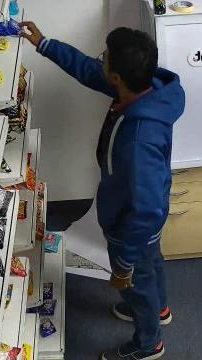

In [99]:
ex = ds_detected['test'][7]
ex['image']

In [100]:
inputs = processor(ex['image'], return_tensors='pt')

In [103]:
# logits = model(**inputs).logits

# logits

In [104]:
logits = model(inputs['pixel_values'].to(device)).logits

logits

tensor([[ 2.6113, -2.9863]], device='cuda:0', grad_fn=<ToCopyBackward0>)

In [105]:
 logits.argmax(-1).item()

0

In [107]:
# array = np.array(ds_train["train"]['labels'])
# array.sum()/array.shape[0]

In [108]:
softmax = torch.nn.Softmax()

def image_to_prob(img):
    inputs = processor(img, return_tensors='pt')
    logits = model(inputs['pixel_values'].to(device)).logits
    return float(softmax(logits)[0][1])

In [160]:
logits.cpu().data.numpy()

[array([     1.6357,     -1.9238], dtype=float32)]

In [162]:
def get_logits(img):
    inputs = processor(img, return_tensors='pt')
    return model(inputs['pixel_values'].to(device)).logits.cpu().data.numpy()

In [163]:
torch.cuda.empty_cache()

In [164]:
logits_test = []
for i in tqdm(range(0, ds_detected['test'].num_rows)):
  logits_test.append(get_logits(ds_detected['test'][i]['image']))
  #logits_test.append(image_to_prob(ds_detected['test'][i]['image']))

  0%|          | 0/315 [00:00<?, ?it/s]

In [175]:
preds = np.array(logits_test).argmax(-1).flatten()

In [176]:
probs = []
for i in tqdm(range(0, ds_detected['test'].num_rows)):
  probs.append(image_to_prob(ds_detected['test'][i]['image']))

  0%|          | 0/315 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [182]:
from sklearn.metrics import roc_auc_score

roc_auc_score(ds_detected['test']['labels'], probs)

0.9979987062343334

In [183]:

roc_auc_score(ds_detected['test']['labels'], preds)

0.9678175790409964

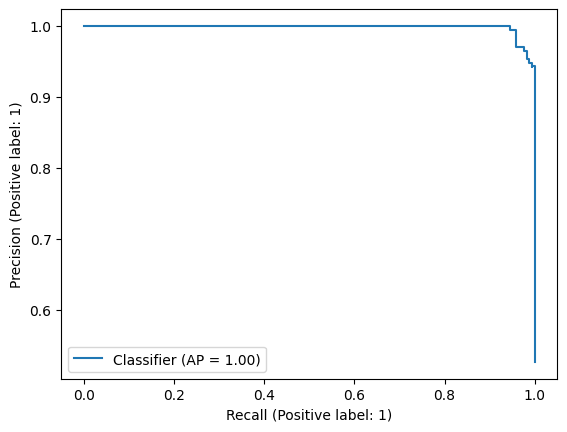

In [189]:
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_predictions(ds_detected['test']['labels'], probs)
plt.show()